# TARRANT Bulletin Map Data Import Script 

##### Last modified:

Version 2.03  
Date: December 20, 2016  
Modified by: Evan Solty  
Note: 
Fix remove 6,7,8,9 values from virus fields function

Version 2.02  
Date: December 20, 2016  
Modified by: Evan Solty  
Note: 
Change pandas.pivot_table(places,index=["MSC"]... to pandas.pivot_table(places,index=["MSC_ID"] due to the name of the field in the spreadsheet.  
Remove tarrant folder to export shps to. Shps still export to own folders.
Add year month day to shps created

Version 2.01  
Date: December 6, 2016  
Modified by: Evan Solty  
Note: Add field "inset" to virus points, Add Edmonton and Calgary community geojson files, points in these polygons recieve a inset = 1  

Version 2.00  
Date: December 4th, 2016   
Modified by: Evan Solty   
Note: Create script based on version 1   


### Description:

Please use what you like for Tarrant work. Script may need modification if input spreadsheet is formatted differently or contains some irregularities ie different field names, contains spaces, different field types etc.  

I'd suggest using https://cloud.sagemath.com to run this on their Anaconda Python 3 kernel. It's free for basic service and this open source python GIS environment is a bit time consuming to set up on your own.

Any questions feel free and email me at evansolty@gmail.com

### Objective: 
To process data for mapping in Tarrant weekly Bulletin. 

### Inputs:
Excel spreadsheet and health zone geojson file in the same directory are required. Edmonton and Calgary communities geojson files are needed to intersect points and indicate if they are in the inset maps. 

### Outputs:
The outputs include a point shapefile containing all the lab confirmed samples by MSC and a polygon shapefile containing the health zones with the total samples collected in each zone as a field.

### Instructions: 
The jupyter notebook can be run https://cloud.sagemath.com with a Anaconda Python 3 kernel. There is a free option.

### Steps needed for data processing for Tarrant GIS work

##### 0. Pre processing
    - Import these files into sagecloudmath
        -Calgary_Community_Boundaries.geojson
        -Edmonton_Neighbourhood_Boundaries.geojson
        -AHS_Zones5_WGS84.json
        -TARRANT_bulletindataimport_version_2.ipynb
        -"current bulletin spreadsheet.xlsx"
    - Check fieldnames and correct
        - for spaces before after column names
        - for spaces after or before numbers in columns
        - for consistency in field name itself from prior week
    - change to
        - weekly_data = "current bulletin spreadsheet.xlsx"


##### 1. Excel data import and processing

    - weekly bulletin data
        - remove spaces
        - convert 7,8,9 values to zero
        - identify the columns the viruses are in (Review where it starts)
        - create a total samples field
        - sum virus counts by MSC (Review fieldname being used) 

##### 2. Spatial data import and processing

    - create geometries
    - project
    - spatial join on polygons getting total samples from points
    - check if points are in Edmonton or Calgary and give inset = 1 to those that are

##### 3. Verification Mapping

    - plot

##### 4. Exporting into shapefiles

    - export to shapefile. shapefiles are in their own folders    

Python GIS library descriptions

('http://spatialdemography.org/essential-python-geospatial-libraries/')

In [80]:
# Import libraries, needs trimming

import geojson
import xlrd
import json
import matplotlib.pyplot as plt
from geopandas.tools import sjoin
import pyproj
import fiona
import pandas
import geopandas
import geopandas.tools
from shapely.geometry import Point
import numpy as np

## 1 Excel data import and processing

In [81]:
# place file in directory, copy filename below
weekly_data = 'Bulletin Data week 40-48.xlsx'

from xlrd import open_workbook
wb = open_workbook(weekly_data)
   
# make list of values
for s in wb.sheets():
    values = []
    for row in range(s.nrows):
        col_value = []
        for col in range(s.ncols):
            value  = (s.cell(row,col).value)
            col_value.append(value)
        values.append(col_value)
print(values[0:5])

[['MSC_ID', 'Lat', 'Long', 'ACCDATE', 'Week', 'RTFLUB', 'RTSWINEH1', 'RTH3'], [184.0, 51.045049, -113.96722, 42646.0, 40.0, 0.0, 0.0, 0.0], [23.0, 50.962363, -114.085499, 42647.0, 40.0, 0.0, 0.0, 0.0], [34.0, 53.535698, -113.32565, 42647.0, 40.0, 0.0, 0.0, 0.0], [43.0, 49.686805, -112.818685, 42647.0, 40.0, 0.0, 0.0, 0.0]]


In [82]:
''' Identify where the virus columns start
in this list they start at column 6
['MSC', 'Lat', 'Long', 'ACCDATE', 'Week', 'RTFLUB', 'RTSWINEH1', 'RTH3']
'''
virus_col_start = 6

number_of_virus_columns = len(values[1][virus_col_start-1:])

print('the number of virus columns is ',number_of_virus_columns, 'please correct if not')

the number of virus columns is  3 please correct if not


In [83]:
# Create a DataFrame with spreadsheet columns and values
places = pandas.DataFrame(values[1:],columns =values[0])

# Remove 6,7,8,9 which are null values
# remove spaces and 7,8,9 values which should be zero
def remove_6789(value):
    try:
        if int(value) > 5 and int(value) < 10:
            value = 0
            return value
        else:
            return value
    except:
        return value
for index, place in places.iterrows():
    for i in range(virus_col_start-1,virus_col_start-1+number_of_virus_columns):
        place[i] = remove_6789(place[i])

# Create a total samples field
total_samples_list = []

for i in range(len(places)):
    total_sample_first_sum = 0
    for num in range(number_of_virus_columns):
        total_sample_first_sum += places.iloc[i][values[0][virus_col_start-1+num]]              
    if total_sample_first_sum == 0:
        total_sample_first_sum = 1
    total_samples_list.append(total_sample_first_sum)
places['total_samples'] = total_samples_list  

# Sum Virus fields and total samples field and keep lat and long field
# if more virus fields are present this needs to be modified
table = pandas.pivot_table(places,index=["MSC_ID"],values=['Lat', 'Long', 'RTFLUB', 'RTSWINEH1', 'RTH3', 'total_samples'],
               aggfunc={'Lat':np.median,'Long':np.median,"RTFLUB":np.sum,"RTSWINEH1":np.sum,"RTH3":np.sum,'total_samples':np.sum})

places = table
places.reset_index(0, drop=False)

,MSC_ID,Lat,Long,RTFLUB,RTH3,RTSWINEH1,total_samples
0,5.0,50.037848,-110.717436,0.0,2.0,0.0,11.0
1,6.0,49.870290,-111.381345,0.0,1.0,0.0,4.0
2,12.0,50.900475,-113.948962,0.0,0.0,0.0,1.0
3,17.0,51.186938,-114.475785,0.0,1.0,0.0,4.0
4,20.0,51.123830,-114.200916,0.0,0.0,0.0,2.0
5,22.0,51.064876,-113.981714,0.0,0.0,0.0,2.0
6,23.0,50.962363,-114.085499,0.0,0.0,0.0,4.0
7,30.0,51.814778,-114.634305,0.0,0.0,0.0,1.0
8,33.0,53.488296,-113.499188,0.0,1.0,0.0,4.0
9,34.0,53.535698,-113.325650,0.0,1.0,0.0,4.0


## 2. Spatial data import and processing

In [84]:
# filename of health zone polygons, can be json or shp, needs to be in same directory
AHS_Zones_WGS84 = 'AHS_Zones5_WGS84.json'

# Create the geometry column from the coordinates
# longitude is east-west (i.e. X) and latitude is north-south (i.e. Y)
places["geometry"] = places.apply(lambda row: Point(row["Long"], row["Lat"]), axis=1)
del(places["Long"], places["Lat"])

# Convert to a GeoDataFrame
places = geopandas.GeoDataFrame(places, geometry="geometry")

# Declare the coordinate system for the places GeoDataFrame
# GeoPandas doesn't do any transformations automatically when performing
# the spatial join. The layers are already in the same CRS (WGS84) so no
# transformation is needed.

# WGS84
places.crs = {"init": "epsg:4326"}

# Load the health zone polygons
health_zones = geopandas.GeoDataFrame.from_file(AHS_Zones_WGS84)
# Drop all columns except the label and polygon geometry
health_zones = health_zones[["HSA_Label", "geometry"]]

# Perform the spatial join, sample fields need to start in 6th column of spreadsheet, or else change
result = geopandas.tools.sjoin(places, health_zones, how="left")
pointSumByPoly = result.groupby('HSA_Label')['total_samples'].sum()#agg(['sum'])
result_sum = health_zones.join(pointSumByPoly, on ="HSA_Label", how="left")

# Print the results...
print(result_sum.head())

       HSA_Label                                           geometry  \
0     South Zone  POLYGON ((-110.0050516742412 51.70297504447153...   
1   Central Zone  POLYGON ((-112.2268724008351 54.05651155668615...   
2  Edmonton Zone  POLYGON ((-113.3478122706558 53.97975626070254...   
3     North Zone  POLYGON ((-110.0000164453658 59.99988138467467...   
4   Calgary Zone  POLYGON ((-117.1312559648432 52.25008157043052...   

   total_samples  
0           35.0  
1           25.0  
2           20.0  
3            4.0  
4           87.0  


In [85]:
# Add calgary and edmonton geojson files

calgary_communities_filename = 'Calgary_Community_Boundaries.geojson'
edmonton_communities_filename = 'Edmonton_Neighbourhood_Boundaries.geojson'

cal_poly = geopandas.GeoDataFrame.from_file(calgary_communities_filename)
ed_poly = geopandas.GeoDataFrame.from_file(edmonton_communities_filename)

# Create inset field, inset = 1 if point is in Edmonton or Calgary
inset = []
for index, place in places.iterrows():
    field = 0
    for index2, ed_polygon in ed_poly.iterrows():
       if place['geometry'].intersects(ed_polygon['geometry']):
          field = 1
    for index3, cal_polygon in cal_poly.iterrows():
       if place['geometry'].intersects(cal_polygon['geometry']):
          field = 1
    inset.append(field)


places['inset'] = inset
places.reset_index(0, drop=False)
places

,RTFLUB,RTH3,RTSWINEH1,total_samples,geometry,inset
MSC_ID,,,,,,
5.0,0.0,2.0,0.0,11.0,POINT (-110.717436 50.037848),0
6.0,0.0,1.0,0.0,4.0,POINT (-111.381345 49.87029),0
12.0,0.0,0.0,0.0,1.0,POINT (-113.948962 50.900475),1
17.0,0.0,1.0,0.0,4.0,POINT (-114.475785 51.186938),0
20.0,0.0,0.0,0.0,2.0,POINT (-114.200916 51.12383),1
22.0,0.0,0.0,0.0,2.0,POINT (-113.981714 51.064876),1
23.0,0.0,0.0,0.0,4.0,POINT (-114.085499 50.962363),1
30.0,0.0,0.0,0.0,1.0,POINT (-114.634305 51.814778),0
33.0,0.0,1.0,0.0,4.0,POINT (-113.499188 53.488296),1


## 3. Verification Mapping

In [86]:
# Project to 10 TM Alberta for mapping
#http://spatialreference.org/ref/epsg/nad83-alberta-10-tm-resource/
health_zones_virus_frequencies = result_sum.to_crs({'init': 'epsg:3401'})
virus_cases = places.to_crs({'init': 'epsg:3401'})

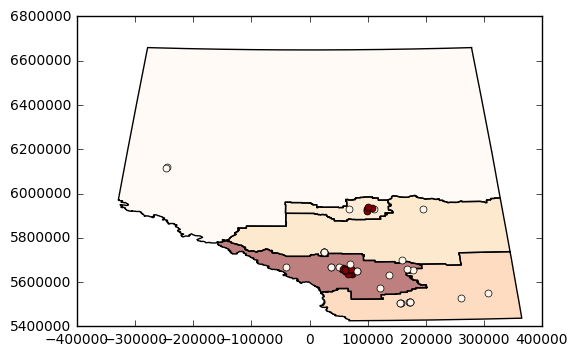

In [87]:
# display all samples collected 
fig, ax = plt.subplots(1)
health_zones_virus_frequencies.plot(column = 'total_samples',ax=ax, cmap='OrRd')#color="#cccccc"
virus_cases.plot(column = 'inset',ax=ax, markersize=5, cmap='OrRd')
plt.show()

## 4. Exporting into shapefiles

In [88]:
# exporting into shapefiles for mapping
import time
timestr = time.strftime("%Y%m%d")
health_zones_virus_frequencies.to_file('ABHZ_freqs_'+timestr)
virus_cases.to_file('virus_cases_'+timestr)